In [1]:
!pip install pandas pillow matplotlib scikit-learn

In [2]:
!pip install torch torchvision

## 1. Read Dataset

In [3]:
import pandas as pd

PROJECT_DIR=r"C:\Users\sneha\OneDrive\Desktop\AIMONK"
IMAGE_DIR=r"C:\Users\sneha\OneDrive\Desktop\AIMONK\images"

In [4]:
def get_data(name):
    file_name=f"{name}.txt"
    file_path=os.path.join(PROJECT_DIR,IMAGE_DIR,file_name)
    return pd.read_txt(file_path)

In [5]:
import os
import pandas as pd

def get_data(name):
    file_name = f"{name}.txt"
    file_path = os.path.join(PROJECT_DIR,file_name)

    df = pd.read_csv(
        file_path,
        sep=r"\s+",          # split on spaces
        header=None
    )

    df.columns = ["image", "Attr1", "Attr2", "Attr3", "Attr4"]

    return df

In [6]:
ml_prob = get_data("labels")
ml_prob.head()

,image,Attr1,Attr2,Attr3,Attr4
0,image_0.jpg,1.0,NaN,0.0,1.0
1,image_1.jpg,NaN,0.0,0.0,0.0
2,image_2.jpg,1.0,1.0,0.0,0.0
3,image_3.jpg,1.0,1.0,0.0,0.0
4,image_4.jpg,1.0,1.0,0.0,0.0


In [7]:
ml_prob.isna().sum()

image     0
Attr1    80
Attr2    91
Attr3    93
Attr4    94
dtype: int64

In [8]:
ml_prob["exists"] = ml_prob["image"].apply(
    lambda x: os.path.exists(os.path.join(IMAGE_DIR, x))
)

ml_prob["exists"].value_counts()

exists
True     972
False      3
Name: count, dtype: int64

In [9]:
ml_prob = ml_prob[ml_prob["exists"] == True].reset_index(drop=True)

In [10]:
for col in ["Attr1","Attr2","Attr3","Attr4"]:
    print(col)
    print(ml_prob[col].value_counts(dropna=False))

Attr1
Attr1
1.0    786
0.0    106
NaN     80
Name: count, dtype: int64
Attr2
Attr2
1.0    710
0.0    171
NaN     91
Name: count, dtype: int64
Attr3
Attr3
1.0    464
0.0    416
NaN     92
Name: count, dtype: int64
Attr4
Attr4
0.0    812
NaN     92
1.0     68
Name: count, dtype: int64


In [11]:
# convert NA to 1(for masking)
ml_prob = ml_prob.replace("NA", -1)

for col in ["Attr1","Attr2","Attr3","Attr4"]:
    ml_prob[col] = ml_prob[col].astype(float)

In [12]:
## Train and validation split
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    ml_prob,
    test_size=0.2,
    random_state=42
)

In [13]:
## full image path
train_df["image_path"] = train_df["image"].apply(lambda x: os.path.join(IMAGE_DIR, x))
val_df["image_path"]   = val_df["image"].apply(lambda x: os.path.join(IMAGE_DIR, x))

In [30]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class MultiLabelDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.attrs = ["Attr1","Attr2","Attr3","Attr4"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image = Image.open(row.image_path).convert("RGB")

        labels = torch.tensor(row[self.attrs].values.astype(float), dtype=torch.float32)

        mask = (labels != -1).float()
        labels[labels == -1] = 0

        if self.transform:
            image = self.transform(image)

        return image, labels, mask

In [31]:
## Transforms
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [32]:
## Dataloaders
from torch.utils.data import DataLoader

train_ds = MultiLabelDataset(train_df, train_tfms)
val_ds   = MultiLabelDataset(val_df, val_tfms)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

In [33]:
## set device
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [34]:
## load pretrained model
import torch.nn as nn
import torchvision.models as models

model = models.resnet50(weights="IMAGENET1K_V1")

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 4)

model = model.to(DEVICE)


In [35]:
train_df = train_df.fillna(-1)
val_df   = val_df.fillna(-1)

In [36]:
# compute pos weights
import numpy as np

labels = train_df[["Attr1","Attr2","Attr3","Attr4"]].values

mask = labels != -1
labels = np.where(labels == -1, 0, labels)

pos = (labels * mask).sum(axis=0)
neg = ((1 - labels) * mask).sum(axis=0)

pos_weight = torch.tensor(neg / (pos + 1e-6), dtype=torch.float32).to(DEVICE)

print(pos_weight)

tensor([ 0.1394,  0.2282,  0.8877, 12.0000])


In [37]:
print(train_df[["Attr1","Attr2","Attr3","Attr4"]].isna().sum())

Attr1    0
Attr2    0
Attr3    0
Attr4    0
dtype: int64


In [38]:
## loss function(masked BCE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')

In [39]:
def masked_loss(outputs, targets, mask):
    loss = criterion(outputs, targets)
    loss = loss * mask

    valid = mask.sum()
    

    if valid == 0:
        return torch.tensor(0.0, device=outputs.device)

    return loss.sum() / (mask.sum() + 1e-6)

In [40]:
for param in model.layer4.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [41]:
print("mask sum:", mask.sum().item())

mask sum: 2824


In [42]:
print(pos_weight)
print(torch.isnan(pos_weight).any())

images, labels, mask = next(iter(train_loader))
print(images.min(), images.max())

outputs = model(images.to(DEVICE))
print(torch.isnan(outputs).any(), outputs.abs().max())

tensor([ 0.1394,  0.2282,  0.8877, 12.0000])
tensor(False)
tensor(-2.1179) tensor(2.6400)
tensor(False) tensor(0.6166, grad_fn=<MaxBackward1>)


In [45]:
losses = []
iteration = 0
EPOCHS = 15

for epoch in range(EPOCHS):

    model.train()

    for images, labels, mask in train_loader:

        images = images.to(DEVICE)
        labels = labels.to(DEVICE).float()
        mask = mask.to(DEVICE)

        
        outputs = model(images)
            
        loss = masked_loss(outputs, labels, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        iteration += 1

        print(f"Epoch {epoch+1} | Iter {iteration} | Loss {loss.item():.4f}")

Epoch 1 | Iter 1 | Loss 0.4296
Epoch 1 | Iter 2 | Loss 0.4145
Epoch 1 | Iter 3 | Loss 0.4450
Epoch 1 | Iter 4 | Loss 0.5095
Epoch 1 | Iter 5 | Loss 0.5981
Epoch 1 | Iter 6 | Loss 0.4105
Epoch 1 | Iter 7 | Loss 0.6427
Epoch 1 | Iter 8 | Loss 0.5114
Epoch 1 | Iter 9 | Loss 0.4302
Epoch 1 | Iter 10 | Loss 0.5131
Epoch 1 | Iter 11 | Loss 0.6706
Epoch 1 | Iter 12 | Loss 0.5008
Epoch 1 | Iter 13 | Loss 0.4592
Epoch 1 | Iter 14 | Loss 0.4304
Epoch 1 | Iter 15 | Loss 0.4245
Epoch 1 | Iter 16 | Loss 0.6079
Epoch 1 | Iter 17 | Loss 0.3896
Epoch 1 | Iter 18 | Loss 0.8734
Epoch 1 | Iter 19 | Loss 0.7226
Epoch 1 | Iter 20 | Loss 0.4047
Epoch 1 | Iter 21 | Loss 0.5919
Epoch 1 | Iter 22 | Loss 0.6649
Epoch 1 | Iter 23 | Loss 0.6085
Epoch 1 | Iter 24 | Loss 0.4288
Epoch 1 | Iter 25 | Loss 0.5396
Epoch 1 | Iter 26 | Loss 0.4120
Epoch 1 | Iter 27 | Loss 0.5818
Epoch 1 | Iter 28 | Loss 0.4287
Epoch 1 | Iter 29 | Loss 0.4506
Epoch 1 | Iter 30 | Loss 0.4062
Epoch 1 | Iter 31 | Loss 0.6950
Epoch 1 | Iter 32

In [46]:
torch.save(model.state_dict(), "aimonk_multilabel_resnet50.pth")

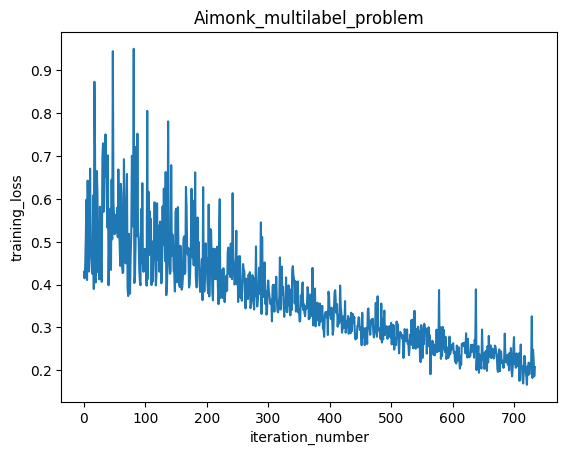

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)
plt.xlabel("iteration_number")
plt.ylabel("training_loss")
plt.title("Aimonk_multilabel_problem")
plt.savefig("loss_curve.png")
plt.show()

In [48]:
iters_per_epoch = len(train_loader)

epoch_losses = [
    sum(losses[i:i+iters_per_epoch]) / iters_per_epoch
    for i in range(0, len(losses), iters_per_epoch)
]

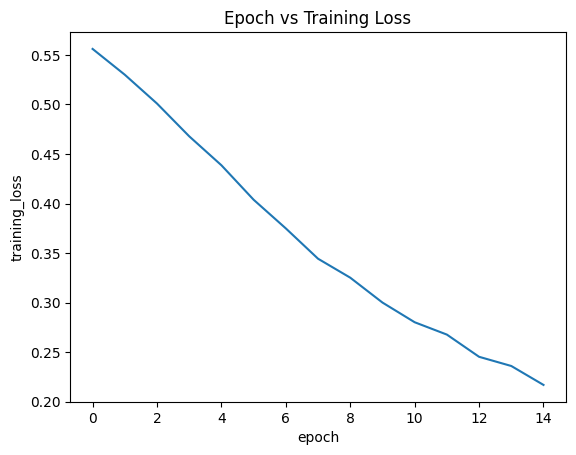

In [49]:
plt.plot(epoch_losses)
plt.xlabel("epoch")
plt.ylabel("training_loss")
plt.title("Epoch vs Training Loss")
plt.show()

In [50]:
plt.savefig("loss_curve.png")

<Figure size 640x480 with 0 Axes>

In [51]:
from sklearn.metrics import f1_score
import numpy as np

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels, mask in val_loader:

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        preds = (probs > 0.5).cpu().numpy()
        targets = labels.cpu().numpy()

        all_preds.append(preds)
        all_targets.append(targets)

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

print("Validation F1 score:", f1_score(all_targets, all_preds, average="macro"))

Validation F1 score: 0.4757039846386376
